# Stock Price Prediction (BBCA)

## by Nurul Amira

#### Dataset diambil dari platform penyedia informasi saham (Yahoo Finance)
1. Prediksi saham akan dilakukan menggunakan dataset saham BBCA (PT Bank Cental Asia Tbk)
2. Histori saham diambil dari rentang tanggal 10-07-2015 sampai 10-07-2023
3. Prediksi akan dilakukan menggunakan Artificial Reccurent Neural Network (RNN)
4. RNN yang akan digunakan adalah model LSTM (Long Short Term Memory)
5. LSTM akan memprediksi harga penutupan (close) dari saham BBCA

In [1]:
#import libraries
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
plt.style.use('fivethirtyeight')

In [2]:
# menampilkan dataset
df = pd.read_csv('BBCA.JK.csv').dropna(axis=0)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-10,2650.0,2680.0,2650.0,2660.0,2340.492188,42836500
1,2015-07-13,2660.0,2710.0,2660.0,2700.0,2375.687500,53040500
2,2015-07-14,2710.0,2730.0,2700.0,2720.0,2393.285889,41833500
3,2015-07-15,2695.0,2700.0,2680.0,2700.0,2375.687500,61445000
4,2015-07-22,2715.0,2715.0,2655.0,2710.0,2384.486328,89975500
...,...,...,...,...,...,...,...
1983,2023-07-03,9025.0,9075.0,9025.0,9075.0,9075.000000,108855900
1984,2023-07-04,9150.0,9150.0,9050.0,9050.0,9050.000000,35049300
1985,2023-07-05,9050.0,9075.0,9025.0,9050.0,9050.000000,44609200
1986,2023-07-06,9050.0,9100.0,9025.0,9075.0,9075.000000,52532400


#### Eksplorasi Dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1988 entries, 0 to 1987
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1988 non-null   object 
 1   Open       1988 non-null   float64
 2   High       1988 non-null   float64
 3   Low        1988 non-null   float64
 4   Close      1988 non-null   float64
 5   Adj Close  1988 non-null   float64
 6   Volume     1988 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 108.8+ KB


In [4]:
# menampilkan jumlah kolom dan baris yang dimiliko oleh dataset
df.shape

(1988, 7)

In [5]:
df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis='columns', inplace=True)

In [6]:
# mengubah tanggal menjadi index
con = df['Date']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
# cek tipe data dari index
df.index

DatetimeIndex(['2015-07-10', '2015-07-13', '2015-07-14', '2015-07-15',
               '2015-07-22', '2015-07-23', '2015-07-24', '2015-07-27',
               '2015-07-28', '2015-07-29',
               ...
               '2023-06-21', '2023-06-22', '2023-06-23', '2023-06-26',
               '2023-06-27', '2023-07-03', '2023-07-04', '2023-07-05',
               '2023-07-06', '2023-07-07'],
              dtype='datetime64[ns]', name='Date', length=1988, freq=None)

In [7]:
# menampilkan df
df

,Close
Date,
2015-07-10,2660.0
2015-07-13,2700.0
2015-07-14,2720.0
2015-07-15,2700.0
2015-07-22,2710.0
...,...
2023-07-03,9075.0
2023-07-04,9050.0
2023-07-05,9050.0


In [8]:
# menginisialkan variabel Close sebagai data time series
ts = df['Close']
ts.head(10)

Date
2015-07-10    2660.0
2015-07-13    2700.0
2015-07-14    2720.0
2015-07-15    2700.0
2015-07-22    2710.0
2015-07-23    2750.0
2015-07-24    2745.0
2015-07-27    2690.0
2015-07-28    2600.0
2015-07-29    2570.0
Name: Close, dtype: float64

#### Visualisasi Close Price History

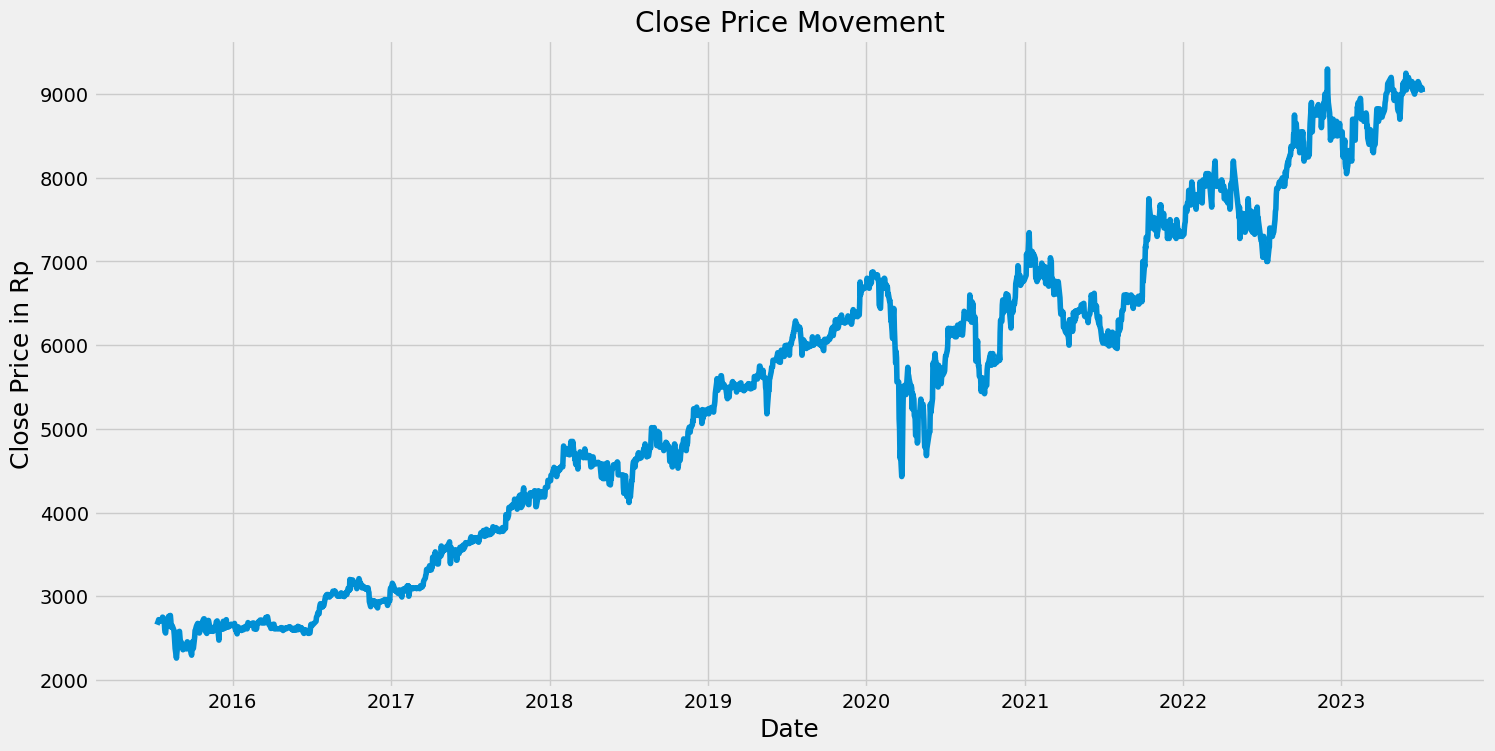

In [9]:
plt.figure(figsize=(16,8))
plt.title('Close Price Movement')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price in Rp', fontsize=18)
plt.show()

#### Uji Stasioneritas Data
membuat data frame baru dengan Close dan diubah ke dalam bentuk array. Keudian variabel digunakan untuk menyimpan dataset. Dengan taining dataset 80% dan Testing dataset 20%

In [10]:
# membuat dataframe baru dari kolom Close
data = df.filter(['Close'])
# konversi dataframe menjadi numpy array
dataset = data.values
len(dataset)

1988

In [11]:
# menghitung jumlah baris pada model untuk di training
training_data_size = math.ceil(len(dataset)*.8)
training_data_size

1591

#### sekarang skala kumpulan data menjadi nilai antara 0 dan 1

In [12]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.05681818],
       [0.0625    ],
       [0.06534091],
       ...,
       [0.96448864],
       [0.96803977],
       [0.9609375 ]])

Membuat kesimpulan dataset yang berisi nilai harga Close 50 hari terakhir yang digunakan untuk memprediksi nilai harga Close ke-51. Jadi kolom pertama dalam dataset 'x_train' berisi nilai dari dataset index 0 hingga 49 (total nilai 50) dan kolom kedua berisi nilai dari dataset index ke-1 hingga index ke-50 (50 nilai) dan seterusnya. Kumpulan data 'y_train' berisi nilai ke-51 yang terletak pada index ke-50 untuk kolom pertama dan nilai ke-52 yang terletak pada index ke-51 dari dataset untuk nilai kedua dan seterusnya.

In [13]:
# membuat scaled training dataset
train_data = scaled_data[0:training_data_size,:]
# memisahkan data x_train dan y_train pada dataset
x_train = []
y_train = []
for i in range (50, len(train_data)):
    x_train.append(train_data[i-50:i, 0])
    y_train.append(train_data[i-0])
    if i<=51:
        print(x_train)
        print(y_train)

[array([0.05681818, 0.0625    , 0.06534091, 0.0625    , 0.06392045,
       0.06960227, 0.06889205, 0.06107955, 0.04829545, 0.04403409,
       0.04261364, 0.05113636, 0.05539773, 0.05681818, 0.06818182,
       0.07102273, 0.06960227, 0.07244318, 0.06392045, 0.05255682,
       0.05397727, 0.05539773, 0.04758523, 0.03977273, 0.02769886,
       0.01633523, 0.        , 0.00923295, 0.015625  , 0.03693182,
       0.04403409, 0.04545455, 0.03622159, 0.02769886, 0.02840909,
       0.02698864, 0.01775568, 0.01420455, 0.01775568, 0.01775568,
       0.01775568, 0.02272727, 0.01846591, 0.015625  , 0.02627841,
       0.02769886, 0.02485795, 0.02414773, 0.01633523, 0.01420455])]
[array([0.00497159])]
[array([0.05681818, 0.0625    , 0.06534091, 0.0625    , 0.06392045,
       0.06960227, 0.06889205, 0.06107955, 0.04829545, 0.04403409,
       0.04261364, 0.05113636, 0.05539773, 0.05681818, 0.06818182,
       0.07102273, 0.06960227, 0.07244318, 0.06392045, 0.05255682,
       0.05397727, 0.05539773, 0.047

#### Konversi dataset 'x_train' dan dataset 'y_train' ke numpy sehingga dapat digunakan untuk melatih  model LSTM

In [14]:
# konversi 'x_train' dan dataset 'y_train' ke numpy array
x_train, y_train = np.array(x_train), np.array(y_train)
# mengubah bentuk data yang diterima oleh LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1541, 50, 1)

#### Membangun model LSTM untuk memiliki 2 lapisan LSTM dengan 50 neuron dan 2 lapisan Dense, satu dengan 25 neuron dan yang lainnya dengan 1 neuron

In [15]:
# membuat model LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#### Kompilasi model menggunakan fungsi MSE (Mean Squared Error)

In [16]:
# compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
# train model
model.fit(x_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
1541/1541 [==============================] - 28s 16ms/step - loss: 0.0015
Epoch 2/10
1541/1541 [==============================] - 24s 16ms/step - loss: 5.0418e-04
Epoch 3/10
1541/1541 [==============================] - 26s 17ms/step - loss: 4.5028e-04
Epoch 4/10
1541/1541 [==============================] - 25s 16ms/step - loss: 3.2359e-04
Epoch 5/10
1541/1541 [==============================] - 26s 17ms/step - loss: 3.1241e-04
Epoch 6/10
1541/1541 [==============================] - 26s 17ms/step - loss: 2.7351e-04
Epoch 7/10
1541/1541 [==============================] - 25s 16ms/step - loss: 2.5643e-04
Epoch 8/10
1541/1541 [==============================] - 27s 17ms/step - loss: 2.6315e-04
Epoch 9/10
1541/1541 [==============================] - 26s 17ms/step - loss: 2.5449e-04
Epoch 10/10
1541/1541 [==============================] - 25s 16ms/step - loss: 2.5209e-04


#### Membuat test dataset

In [18]:
# test dataset
test_data = scaled_data[training_data_size-50:, :]
# membuat x_test dan y_test dataset
x_test = []
y_test = dataset[training_data_size:, :]
for i in range(50, len(test_data)):
    x_test.append(test_data[i-50:i, 0])

In [19]:
# konversi x_test ke numpy array
x_test = np.array(x_test)

In [20]:
# membentuk data yang diterima oleh LSTM
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

#### Prediksi Data
Untuk mendapatkan nilai prediksi price values

In [21]:
# mendapatkan nilai harga prediksi model
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

13/13 [==============================] - 1s 12ms/step


In [22]:
predictions

array([[7570.8716],
       [7664.5435],
       [7503.987 ],
       [7525.93  ],
       [7569.264 ],
       [7574.6396],
       [7578.4863],
       [7531.7505],
       [7387.0835],
       [7496.3774],
       [7378.535 ],
       [7403.4033],
       [7592.01  ],
       [7484.735 ],
       [7464.1353],
       [7456.478 ],
       [7525.65  ],
       [7457.563 ],
       [7480.876 ],
       [7407.5254],
       [7404.904 ],
       [7402.3037],
       [7379.6753],
       [7594.0654],
       [7485.104 ],
       [7488.7085],
       [7434.23  ],
       [7406.465 ],
       [7402.6455],
       [7449.8438],
       [7453.4634],
       [7409.079 ],
       [7406.8857],
       [7428.5215],
       [7501.261 ],
       [7553.6064],
       [7582.4814],
       [7750.9883],
       [7709.397 ],
       [7806.6865],
       [7804.554 ],
       [7804.851 ],
       [7944.1094],
       [7852.081 ],
       [7780.564 ],
       [7770.5366],
       [7861.752 ],
       [8033.5425],
       [7902.5776],
       [7879.528 ],


In [23]:
# menghitung nilai RMSE
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

72.7965502991184

C:\Users\asani\AppData\Local\Temp\ipykernel_6448\2008787383.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions


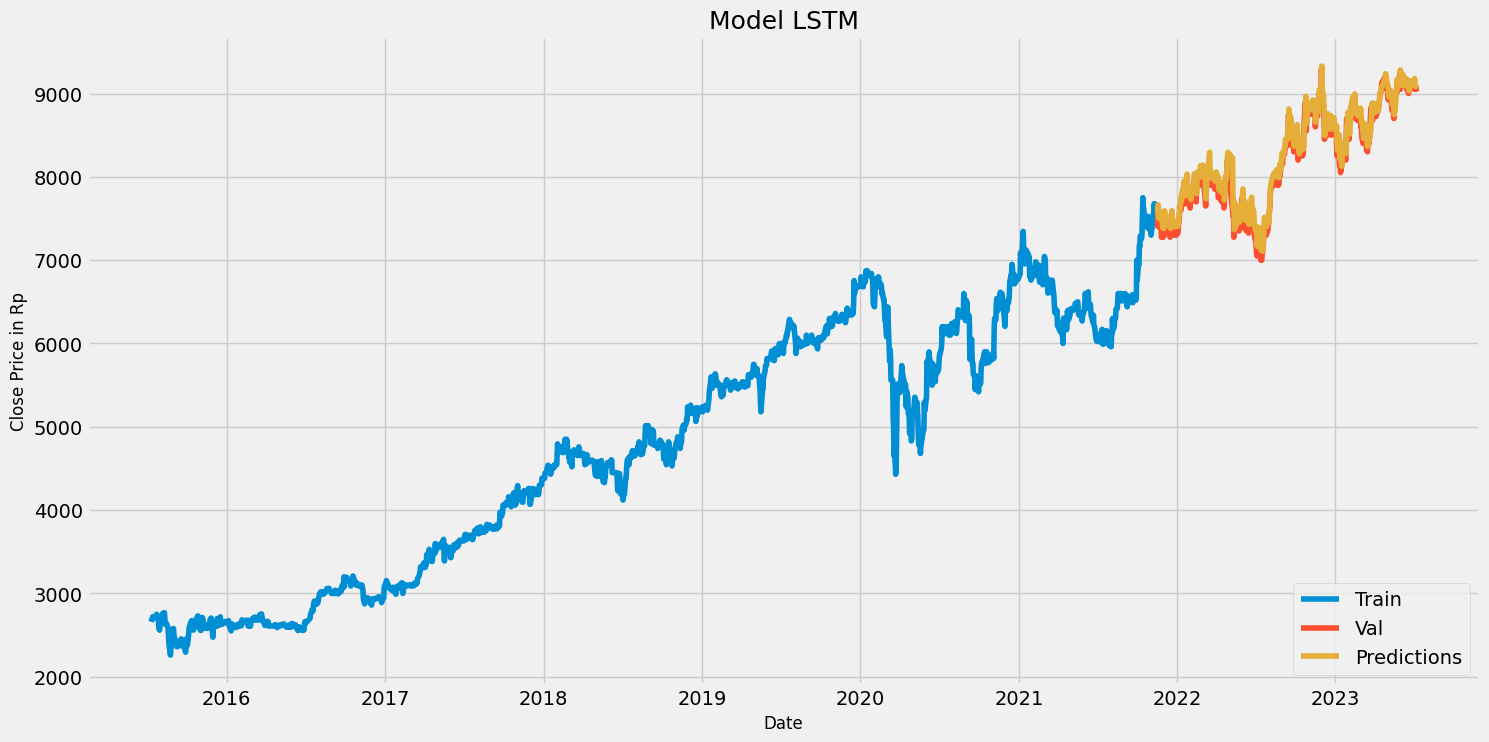

In [24]:
# membuat data untuk grafik
train = data[:training_data_size]
valid = data[training_data_size:]
valid['predictions'] = predictions

# visualisasi data
plt.figure(figsize=(16,8))
plt.title('Model LSTM', fontsize=18)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price in Rp', fontsize=12)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [25]:
# menampilkan data harga yang valid dan prediksi
valid

,Close,predictions
Date,,
2021-11-17,7575.0,7570.871582
2021-11-18,7400.0,7664.543457
2021-11-19,7425.0,7503.986816
2021-11-22,7475.0,7525.930176
2021-11-23,7475.0,7569.264160
...,...,...
2023-07-03,9075.0,9179.788086
2023-07-04,9050.0,9111.138672
2023-07-05,9050.0,9088.503906
